#**Airbus Stock Data Analysis**




## **Analysis**

Importing required libraries

In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

Define stock symbol and time period

In [28]:
stock_symbol = 'AIR.PA' # Replace with your desired stock symbol
start_date = '2001-01-01' # Replace with your desired start date
end_date = datetime.today().strftime('%Y-%m-%d') # End date is today

Download stock data using yfinance

In [59]:
df = yf.download(stock_symbol, start=start_date, end=end_date)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-09-03,19.040001,19.240000,18.920000,18.990000,12.450932,322507
2001-09-04,19.379999,19.940001,19.059999,19.940001,13.073807,2124573
2001-09-05,19.700001,19.930000,19.670000,19.700001,12.916450,1135245
2001-09-06,19.549999,19.700001,19.059999,19.059999,12.496830,1730852
2001-09-07,19.150000,19.350000,18.020000,18.110001,11.873956,1660196
...,...,...,...,...,...,...
2023-05-02,126.900002,127.300003,124.860001,125.360001,125.360001,1376322
2023-05-03,123.800003,126.339996,123.000000,124.400002,124.400002,1103039
2023-05-04,123.000000,124.800003,120.419998,122.099998,122.099998,1824927


Resample to weekly data

In [30]:
dfw = df.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum'
})

Calculate daily and cumulative returns


In [31]:
daily_returns = df['Adj Close'].pct_change()
cumulative_returns = (1 + daily_returns).cumprod() - 1
print('Daily Returns:')
print(daily_returns.describe())
print('\nCumulative Returns:')
print(cumulative_returns.tail())

Calculate rolling mean and standard deviation for the data from 2018

In [70]:
Date_range = df[pd.Timestamp('2018-01-01'):]
window_size = 20 # Number of days in rolling window
rolling_mean = Date_range['Adj Close'].rolling(window_size).mean()
rolling_std = Date_range['Adj Close'].rolling(window_size).std()

Plot the stock price, rolling mean, and rolling standard deviation

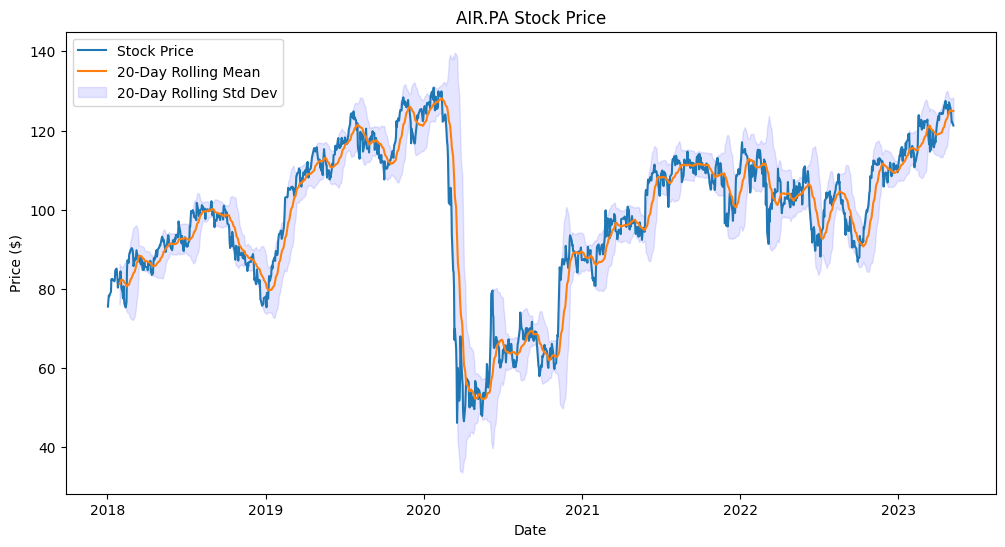

In [71]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(Date_range.index, Date_range['Adj Close'], label='Stock Price')
ax.plot(rolling_mean.index, rolling_mean, label=f'{window_size}-Day Rolling Mean')
ax.fill_between(rolling_std.index, rolling_mean-2*rolling_std, rolling_mean+2*rolling_std, color='b', alpha=0.1, label=f'{window_size}-Day Rolling Std Dev')
ax.set_title(f'{stock_symbol} Stock Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
ax.legend()
plt.show()

Another most commonly used visualisation technique is the Candle-Stick chart which provides an in-depth visualisation of the data. This is especially used to represent stock data. For this chart, we have sliced the data for the years after 2015 so that it can be easier to understand. The past data from the beginning would not really matter if someone wants to look at the recent data.

In [73]:
dfw_2 = dfw[pd.Timestamp('2018-01-05'):]
fig = go.Figure(data=[go.Candlestick(x=dfw_2.index,
                open=dfw_2['Open'],
                high=dfw_2['High'],
                low=dfw_2['Low'],
                close=dfw_2['Close'])])

fig.show()

## **Machine Learning**

Now that we have analysed the data and calculated the OHLC data in the standard form. Let us get started with the Machine Learning part where it all gets much more interesting. First we store the average value of the OHLC data and normalise it for further use.

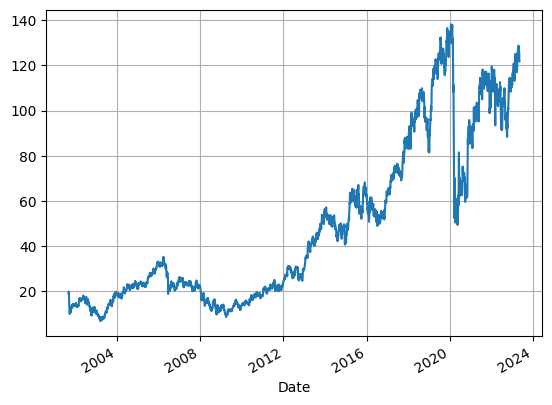

In [37]:
ohlc_avg = df[['Open','High','Low','Close']].mean(axis = 1)
ohlc_avg.plot()
plt.grid()
ohlc_avg = np.reshape(ohlc_avg.values, (len(ohlc_avg),1))
scaler = MinMaxScaler(feature_range=(0,1))
ohlc_avg = scaler.fit_transform(ohlc_avg)

In [38]:
train_ohlc = int(len(ohlc_avg) * 0.75)
test_ohlc = len(ohlc_avg) - train_ohlc
train_ohlc, test_ohlc = ohlc_avg[:train_ohlc,:], ohlc_avg[train_ohlc:len(ohlc_avg),:]

In [39]:
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - step_size - 1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [40]:
train_X, train_Y = new_dataset(train_ohlc, 1)
test_X, test_Y = new_dataset(test_ohlc, 1)

In [41]:
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [42]:
print(train_X.shape, test_X.shape)

(4173, 1, 1) (1390, 1, 1)


In [43]:
model = Sequential()
model.add(LSTM(32, input_shape = (1, 1), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))

In [44]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(train_X, train_Y, epochs = 5, batch_size = 1, verbose = 2)

train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

Epoch 1/5
4173/4173 - 15s - loss: 0.0011 - 15s/epoch - 4ms/step
Epoch 2/5
4173/4173 - 12s - loss: 3.6786e-05 - 12s/epoch - 3ms/step
Epoch 3/5
4173/4173 - 11s - loss: 3.4720e-05 - 11s/epoch - 3ms/step
Epoch 4/5
4173/4173 - 11s - loss: 3.5762e-05 - 11s/epoch - 3ms/step
Epoch 5/5
4173/4173 - 11s - loss: 3.6660e-05 - 11s/epoch - 3ms/step
44/44 [==============================] - 0s 2ms/step


In [45]:
trainPredict = scaler.inverse_transform(train_predict)
train_Y = scaler.inverse_transform([train_Y])
testPredict = scaler.inverse_transform(test_predict)
test_Y = scaler.inverse_transform([test_Y])

In [46]:
testPredict.shape

(1390, 1)

In [47]:
trainScore = math.sqrt(mean_squared_error(train_Y[0], trainPredict[:,0]))
print("Train RMSE: ", round(trainScore,3))

testScore = math.sqrt(mean_squared_error(test_Y[0], testPredict[:,0]))
print("Test RMSE: ", round(testScore,3))

Train RMSE:  0.57
Test RMSE:  4.287


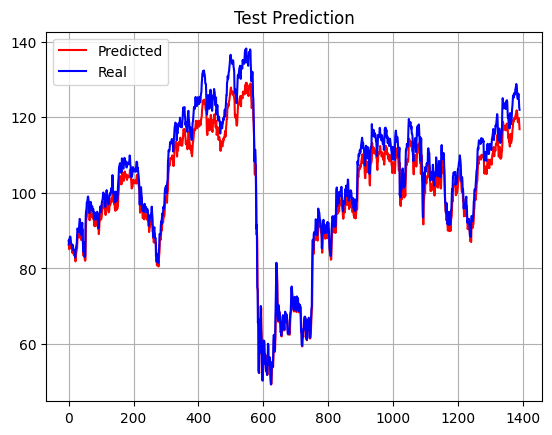

In [48]:
plt.plot(testPredict[:,0], color='Red',label = 'Predicted')
plt.plot(test_Y[0],color ='blue', label = 'Real')
plt.title('Test Prediction')
plt.grid()
plt.legend()

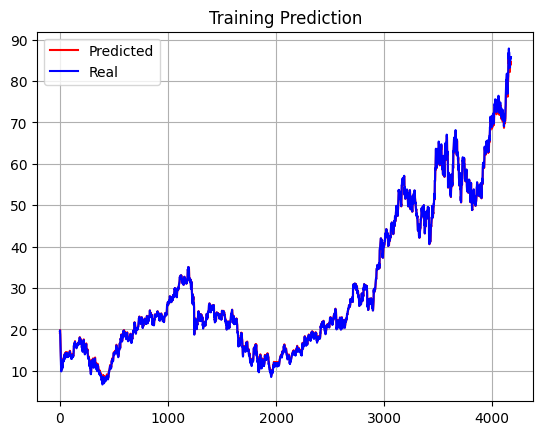

In [49]:
plt.plot(trainPredict[:,0], color = 'red', label = 'Predicted')
plt.plot(train_Y[0],color ='blue', label = 'Real')
plt.title('Training Prediction')
plt.grid()
plt.legend()

In [50]:
model2 = Sequential()
model2.add(LSTM(32, input_shape = (1, 1), return_sequences = True))
model2.add(LSTM(16))
model2.add(Dense(1))
model2.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [51]:
new_ohlc_avg = ohlc_avg.copy()

for i in range(10):
    trainX3, trainY3 = new_dataset(new_ohlc_avg, 1)
    trainX3 = np.reshape(trainX3, (trainX3.shape[0], 1, trainX3.shape[1]))
    model2.fit(trainX3, trainY3, epochs = 5, batch_size = 1, verbose = 2)
    
    last_val = new_ohlc_avg[-1]
    next_val = model2.predict(np.reshape(last_val,(1,1,1)))
    new_ohlc_avg = np.append(new_ohlc_avg, next_val[0])
    new_ohlc_avg = new_ohlc_avg.reshape(-1,1)
    
next_val = scaler.inverse_transform(new_ohlc_avg[-25:])
ohlc_avg = scaler.inverse_transform(ohlc_avg)

Epoch 1/5
5565/5565 - 22s - loss: 0.0033 - 22s/epoch - 4ms/step
Epoch 2/5
5565/5565 - 15s - loss: 1.2578e-04 - 15s/epoch - 3ms/step
Epoch 3/5
5565/5565 - 16s - loss: 1.3307e-04 - 16s/epoch - 3ms/step
Epoch 4/5
5565/5565 - 16s - loss: 1.3040e-04 - 16s/epoch - 3ms/step
Epoch 5/5
5565/5565 - 15s - loss: 1.2504e-04 - 15s/epoch - 3ms/step
1/1 [==============================] - 1s 783ms/step
Epoch 1/5
5566/5566 - 16s - loss: 1.3066e-04 - 16s/epoch - 3ms/step
Epoch 2/5
5566/5566 - 15s - loss: 1.2104e-04 - 15s/epoch - 3ms/step
Epoch 3/5
5566/5566 - 15s - loss: 1.1813e-04 - 15s/epoch - 3ms/step
Epoch 4/5
5566/5566 - 16s - loss: 1.1294e-04 - 16s/epoch - 3ms/step
Epoch 5/5
5566/5566 - 15s - loss: 1.1194e-04 - 15s/epoch - 3ms/step
1/1 [==============================] - 0s 33ms/step
Epoch 1/5
5567/5567 - 15s - loss: 1.0853e-04 - 15s/epoch - 3ms/step
Epoch 2/5
5567/5567 - 15s - loss: 1.0688e-04 - 15s/epoch - 3ms/step
Epoch 3/5
5567/5567 - 17s - loss: 1.0679e-04 - 17s/epoch - 3ms/step
Epoch 4/5
5567/

In [52]:
next_val

array([[127.32999992],
       [127.63500023],
       [128.29500198],
       [128.76999664],
       [128.31500053],
       [127.65500259],
       [125.54000092],
       [124.8599987 ],
       [124.93500137],
       [126.20000076],
       [126.10500145],
       [124.38500023],
       [122.57999992],
       [121.93999863],
       [121.81999969],
       [118.12771863],
       [120.35010716],
       [121.23152198],
       [124.68659505],
       [125.1371024 ],
       [123.97947107],
       [125.84687523],
       [126.86184511],
       [124.92309456],
       [124.7208968 ]])

In [53]:
ohlc_avg

array([[ 19.04750013],
       [ 19.57999992],
       [ 19.75000048],
       ...,
       [122.57999992],
       [121.93999863],
       [121.81999969]])

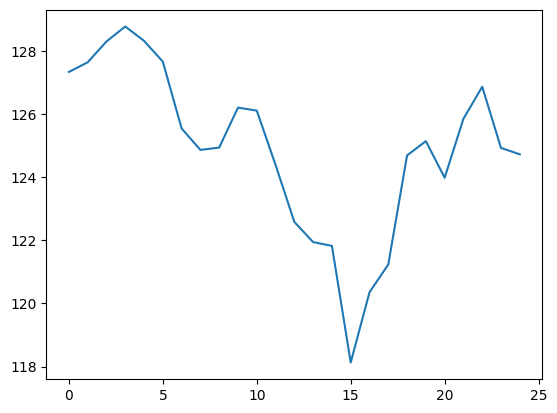

In [54]:
plt.plot(next_val)